In [117]:
pip install nltk


In [118]:
pip install tensorflow


In [119]:
pip install imbalanced-learn


## Imports

In [120]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import re
import statistics as stats
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [121]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Functions/Classes

In [122]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.math.reduce_mean(tf.math.reduce_sum(loss, axis=-1))
    return focal_loss_fixed

In [123]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, train_data):
        super().__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

    def on_epoch_end(self, epoch, logs=None):
        val_X, val_y = self.validation_data
        y_pred_val = (self.model.predict(val_X) > 0.5).astype("int32")

        train_X, train_y = self.train_data
        y_pred_train = (self.model.predict(train_X) > 0.5).astype("int32")

        val_f1 = f1_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_precision = precision_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_recall = recall_score(val_y, y_pred_val, average='weighted', zero_division=0)

        train_f1 = f1_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_precision = precision_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_recall = recall_score(train_y, y_pred_train, average='weighted', zero_division=0)

        self.train_accuracy.append(logs['accuracy'])
        self.val_accuracy.append(logs['val_accuracy'])
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)

  # Display metrics at the end of each epoch

        print(f"\nEpoch {epoch + 1} - Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")


In [124]:


class MetricsCallback_2(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, train_data):
        super().__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

    def on_epoch_end(self, epoch, logs=None):
        # Get validation data
        val_X, val_y = self.validation_data
        train_X, train_y = self.train_data

        # Predict validation and training data
        y_pred_val = np.argmax(self.model.predict(val_X), axis=1)  # Convert to class labels
        y_pred_train = np.argmax(self.model.predict(train_X), axis=1)  # Convert to class labels

        # Calculate validation metrics
        val_f1 = f1_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_precision = precision_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_recall = recall_score(val_y, y_pred_val, average='weighted', zero_division=0)

        # Calculate training metrics
        train_f1 = f1_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_precision = precision_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_recall = recall_score(train_y, y_pred_train, average='weighted', zero_division=0)

        # Store metrics
        self.train_accuracy.append(logs['accuracy'])
        self.val_accuracy.append(logs['val_accuracy'])
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)

        # Print metrics for each epoch
        print(f"\nEpoch {epoch + 1} - Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")


In [125]:
def plot_metrics(metrics_callback):
    epochs = range(1, len(metrics_callback.train_accuracy) + 1)

   # Plotting accuracy

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics_callback.train_accuracy, label='Train Accuracy')
    plt.plot(epochs, metrics_callback.val_accuracy, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting F1-Score
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics_callback.train_f1, label='Train F1-Score')
    plt.plot(epochs, metrics_callback.val_f1, label='Val F1-Score')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plotting precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics_callback.train_precision, label='Train Precision')
    plt.plot(epochs, metrics_callback.val_precision, label='Val Precision')
    plt.title('Precision per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotting recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics_callback.train_recall, label='Train Recall')
    plt.plot(epochs, metrics_callback.val_recall, label='Val Recall')
    plt.title('Recall per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [126]:
def Conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [127]:
def Conf_matrix_2(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## Data Loading

In [128]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [129]:
# Load the data to inspect it

data = pd.read_csv('labeled_data.csv')

# Display the first few rows of the dataset to understand its structure
data.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Data Analysis

In [130]:
print(data.head())
print(data.describe())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
         Unnamed: 0         count   hate_speech  offensive_language  \
count  24783.000000  24783.000000  24783.000000        24783.000000   
mean   12681.192027      3.243473      0.280515            2.413711   
std     7299.55386

In [131]:
class_counts = data['class'].value_counts()


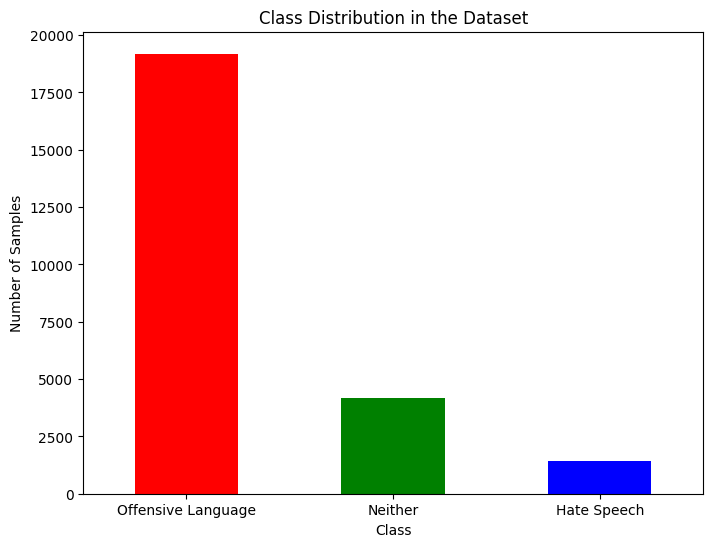

In [132]:
class_labels = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}

plt.figure(figsize=(8, 6))
class_counts.rename(index=class_labels).plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

## Data Preprocessing

In [133]:
# Remove the unnecessary 'Unnamed: 0' column
data_cleaned = data.drop(columns=['Unnamed: 0'])

In [134]:
missing_values = data_cleaned.isnull().sum()


In [135]:
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove special characters and numbers, keeping only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Convert to lowercase
    text = text.lower()

    # Split the text into words and remove stop words

    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Join the words back into a string
    clean_text = ' '.join(words)

    return clean_text

In [136]:
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_tweet)


In [137]:
data_cleaned.head(), missing_values


(   count  hate_speech  offensive_language  neither  class  \
 0      3            0                   0        3      2   
 1      3            0                   3        0      1   
 2      3            0                   3        0      1   
 3      3            0                   2        1      1   
 4      6            0                   6        0      1   
 
                                                tweet  
 0  rt woman shouldnt complain cleaning house amp ...  
 1  rt boy dats coldtyga dwn bad cuffin dat hoe st...  
 2  rt dawg rt ever fuck bitch start cry confused ...  
 3                                rt look like tranny  
 4  rt shit hear might true might faker bitch told ya  ,
 count                 0
 hate_speech           0
 offensive_language    0
 neither               0
 class                 0
 tweet                 0
 dtype: int64)

In [138]:
data_cleaned.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


# LSTM

## Splitting the Dataset and Tokenization

In [139]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned["tweet"], data_cleaned['class'], test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [140]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [141]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length


print(max_length)

25


In [142]:
X_train = pad_sequences(X_train,maxlen=max_length,padding='post')
X_test = pad_sequences(X_test,maxlen=max_length,padding='post')

In [143]:
vocab_size = len(word_index) + 1
embedding_dim = 128
max_length = 25  # Maximum sequence length, defined previously
l2_reg = 0.01  # Regularization term


In [144]:
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

In [145]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


## Modeling

In [146]:
model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),

    # Convolutional layer
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),

    # Batch Normalization
    BatchNormalization(),

    # Max Pooling layer
    MaxPooling1D(pool_size=2),

    # LSTM layer with L2 regularization and dropout
    LSTM(32, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)),

    # Dropout layer to prevent overfitting
    Dropout(0.5),

    # Dense layer with reduced units and L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),

    # Dropout
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(3, activation='softmax'),
])

# Compile the model
model.compile(loss=focal_loss(gamma=2., alpha=0.25), optimizer='adam', metrics=['accuracy'])


## Training/Results

In [147]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [148]:
print("Unique classes in the training set:", np.unique(y_train))


Unique classes in the training set: [0. 1.]


In [149]:
print(f"Type of y_train: {y_train.dtype}")
y_train = y_train.astype('int')


Type of y_train: float32


In [150]:
class_weights_dict = {
    0: 2.0,  # Higher weight for class 0 (minority)
    1: 1.0,  # Default weight for class 1 (dominant class)
    2: 1.5   # Somewhat higher weight for class 2 (moderate class)
}

In [151]:
metrics_callback = MetricsCallback(validation_data=(X_test_padded, y_test), train_data=(X_train_padded, y_train))


In [152]:
import tensorflow as tf

def focal_loss_fixed(y_true, y_pred):
    """
    Focal Loss function with numerical stability improvements.

    Args:
        y_true: True labels (one-hot encoded).
        y_pred: Predicted probabilities.

    Returns:
        Focal loss value.
    """
    gamma = 2.0
    alpha = 0.25
    epsilon = tf.keras.backend.epsilon()  # Small value to avoid division by zero

    # Ensure y_true and y_pred are tensors with the correct data type
    y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    # Calculate cross-entropy
    cross_entropy = -y_true * tf.math.log(y_pred)

    # Calculate focal loss
    focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy

    # Sum the loss across classes
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)

    # Return the average loss
    return tf.reduce_mean(focal_loss)

In [153]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Accuracy on the test set: {test_accuracy}')

155/155 - 1s - loss: 2.2515 - accuracy: 0.7730 - 1s/epoch - 8ms/step
Accuracy on the test set: 0.7730482220649719
